# CBOW实践

## 1. 参数设置及数据预处理

In [53]:
import os
import numpy as np
import torch
import jieba
jieba.setLogLevel(jieba.logging.INFO)
from collections import Counter
from tqdm.notebook import tqdm

### 1.1 **设置参数**

In [31]:
embed_size = 128 #词向量维度
window = 5 #窗口大小
nb_negative = 50 #随机负采样的样本数
min_count = 10 #频数少于min_count的词将会被抛弃，低频词类似于噪声，可以抛弃掉
nb_epoch = 10 #迭代次数
batch_size = 256

### 1.2 **读取数据并构造数据集**

In [3]:
data_dir = './CBOW_Data'

In [4]:
words, corpus = [], []
for file in tqdm(os.listdir(data_dir)[:3000]):
    with open(os.path.join(data_dir, file), 'r') as f:
        for line in f:
            words+=jieba.lcut(line)
            corpus.append(jieba.lcut(line))

  0%|          | 0/3000 [00:00<?, ?it/s]

In [5]:
words = dict(Counter(words))

In [6]:
words = {i:j for i,j in words.items() if j >= min_count}
id2word = {i+2:j for i,j in enumerate(words)}
id2word[0] = 'PAD'
id2word[1] = 'UNK'
word2id = {j:i for i,j in id2word.items()}

#### 在CBOW的训练过程中，需要根据周围词去预测中间词，例如 ["我",  "爱",  "你",  "中国",  "。"]这句话，包含五个token。这时我们将 ["我",  "爱",  "中国",  "。"]作为输入，即中间空出一个单词，我们希望能通过训练得到中间缺少的这个单词。而监督样本的标签则是长度为“负样本数+1”的向量，其中第一个为正样本，其余为随机选取的负样本。

### 1.3 **构建数据集**

In [7]:
from torch.utils.data import Dataset, DataLoader
import random

In [8]:
class CBOW_Dataset(Dataset):
    def __init__(self, words, corpus,window=5, nb_negative=50, min_count=10):
        super(CBOW_Dataset, self).__init__()
        self.words = words
        self.corpus = corpus
        self.window = window
        self.nb_negative = nb_negative
        self.min_count = min_count
        self.words, self.id2word, self.word2id = self._build_members()
        self.nb_word = len(self.id2word)
        self.nb_sentence = len(self.corpus)
        self.context, self.pos_data, self.neg_data = self._build_set()
        
    def _build_members(self):
        words = {i:j for i,j in self.words.items() if j >= self.min_count}
        id2word = {i+2:j for i,j in enumerate(words)}
        id2word[0] = 'PAD'
        id2word[1] = 'UNK'
        word2id = {j:i for i,j in id2word.items()}
        print("构建字典成功...")
        return words, id2word, word2id
    
    def _get_negative_sample(self, x):
        negs = []
        while True:
            rand = random.randrange(0, len(self.words))
            if rand != x and rand not in negs:
                negs.append(rand)
            if len(negs) == self.nb_negative:
                return negs
            
    def _build_set(self):
        context, pos_data, neg_data = [],[],[]
        for sentence in tqdm(corpus):
            sentence = [0]*self.window + [self.word2id[w] for w in sentence if w in self.word2id] + [0]*self.window
            for i in range(self.window, len(sentence)-self.window):
                context.append(sentence[i-self.window: i]+sentence[i+1: self.window+i+1])
                pos_data.append([sentence[i]])
                neg_data.append(self._get_negative_sample(sentence[i]))
        print("构建数据集成功...")
        print("共{}单词，{}语料，{}数据".format(len(self.words), len(self.corpus), len(context)))
        return context, pos_data, neg_data
    
    def __getitem__(self, index):
        return torch.LongTensor(self.context[index]), torch.LongTensor(self.pos_data[index]), torch.LongTensor(self.neg_data[index])
    def __len__(self):
        return len(self.context)
    
    def get_dict(self):
        return self.id2word, self.word2id
        
        
    

In [9]:
data_set = CBOW_Dataset(words, corpus)

构建字典成功...


  0%|          | 0/3000 [00:00<?, ?it/s]

构建数据集成功...
共7398单词，3000语料，864932数据


In [32]:
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [33]:
for n, x, p in data_loader:
    print(x.shape, n.shape, p.shape)
    break

torch.Size([256, 1]) torch.Size([256, 10]) torch.Size([256, 50])


## 2. 模型编写

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
class CBOW_Model(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(CBOW_Model, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.in_embed = nn.Embedding(self.vocab_size, self.embed_size)
        self.out_embed = nn.Embedding(self.vocab_size, self.embed_size)
    
    def forward(self, input_labels, pos_labels, neg_labels):
        input_embedding = self.in_embed(input_labels)
        pos_embedding = self.out_embed(pos_labels)
        neg_embedding = self.out_embed(neg_labels)
        input_embedding = input_embedding.unsqueeze(2)
        pos_dot = torch.bmm(pos_embedding, input_embedding)
        pos_dot = pos_dot.squeeze(2)
        neg_dot = torch.bmm(neg_embedding, -input_embedding)
        neg_dot = neg_dot.squeeze(2)
        log_pos = F.logsigmoid(pos_dot).sum(1)
        log_neg = F.logsigmoid(neg_dot).sum(1)
        loss = log_pos + log_neg
        return -loss
    def input_embedding(self):
        return self.in_embed.weight.detach().numpy()

In [35]:

#dis = math.sqrt(sum([(w[i]-x[i])**2 for i in range(len(w))]))

## 3. 模型训练

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CBOW_Model(len(data_set.id2word), embed_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [37]:
embedding_weights_pre = model.cpu().input_embedding()

In [39]:
loss_plot = []
model = model.to(device)
for epoch in tqdm(range(nb_epoch)):
    np_loss = 0
    num_of_data = 0
    for pos_labels, input_labels, neg_labels in data_loader:
        input_labels = input_labels.to(device).squeeze()
        pos_labels = pos_labels.to(device)
        neg_labels = neg_labels.to(device)  
        num_of_data += len(input_labels)
        optimizer.zero_grad()
        loss = model(input_labels, pos_labels, neg_labels).mean()
        np_loss += loss.detach().cpu().numpy()
        loss.backward()
        optimizer.step()
    loss_plot.append(np_loss/num_of_data)

  0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
embedding_weights = model.cpu().input_embedding()

<IPython.core.display.Javascript object>


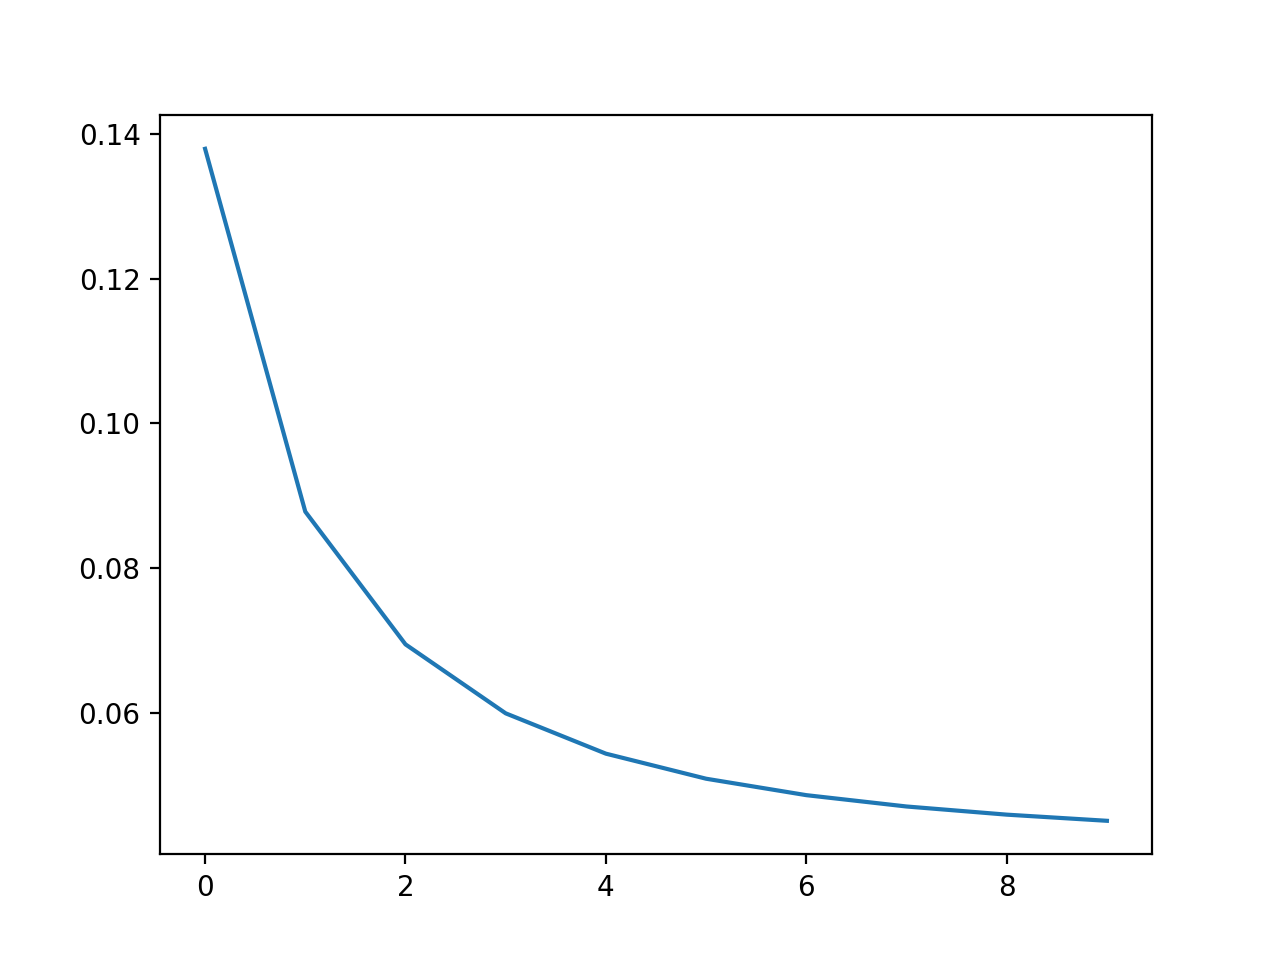

In [41]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False


plt.plot(loss_plot)
plt.show()

## 4. 保存及应用

In [48]:
id2word, word2id = data_set.get_dict()
import scipy.spatial
def find_nearest(word, weights):
    index = word2id[word]
    embedding = weights[index]
    cos_dis = np.array([scipy.spatial.distance.cosine(e, embedding) for e in weights])
    result =  [id2word[i] for i in cos_dis.argsort()[:10]]
    return result

In [51]:
find_nearest('跑', embedding_weights)

['跑', '火炬手', '一棒', '都', '今天', '激动', '当', '那', '火炬', '时候']